# Flowchart
- run yolo model to detect indexes of image volume which corresponding to contrast
- run heart segmentation model based on contrasted-heart indexes
- do post-processing,do convell hull if ration of seg mask to convell is greater than threshold, else skip
- automatically calculate EF rate
- automatically calculate mse of pred/GT EF rate

In [3]:
import os
import cv2
import time
import torch
import imutils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from preprocess_aug_savenpz import area_ratio
from preprocess_aug_savenpz import filled_mask
from preprocess_aug_savenpz import get_dicom_data
from preprocess_aug_savenpz import filter_largest_component
from yolov5.inference import yolo_inference_indexbool
from yolov5.models.experimental import attempt_load
from yolov5.utils.torch_utils import select_device
from inference import seg_model
from inference import seg_inference
from inference import seg_inference_batch
from inference import convexhull
from calculate_ef import automatically_calculate_ef

%matplotlib inline
# parameters
device = "0"
augment = False # TTA
conf_thres=0.9
iou_thres=0.8
imgsz = 512
yolo_weight = "yolov5/weights/01_fintune_stage3_weightv5x6/weights/best.pt"
seg_weight = ("result/"
              "11_mannual_annotation_dataset_512_clahe_aug14_10weight_fine_tune_3stage_sandwich_rescale255_focal_loss_dropout_1e4/"
              "model_15-0.022-0.950.h5")
# load model
# yolo model
device = select_device(device)
yolo_model = attempt_load(yolo_weight, map_location=device)  # load FP32 model
# seg model
model = seg_model(seg_weight)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

load model success


In [4]:
# load images
test = {"image": "../inference_dataset/0661_ant_hypo/0661.dcm", "ground_truth_ef": 0.557} 
start = time.time()
dcm_path = test['image']
image_arr, _ = get_dicom_data(dcm_path)
# inference yolo
index_boolean = yolo_inference_indexbool(device, yolo_model, augment, conf_thres, iou_thres, image_arr, imgsz)
indexes_true = [i for i,x in enumerate(index_boolean) if x == True]
min_contrast, max_contrast = min(indexes_true), max(indexes_true)
print("yolo", time.time()- start)
torch.cuda.empty_cache()
# inference segmentation
y_pred, x = seg_inference_batch(model, dcm_path, threshold=0.5, ifsandwich=True, batch_size=8)
print(time.time()-start)

yolo 5.952569484710693
read image 0.01163625717163086
(129, 512, 512, 3)
preprocess 9.095175504684448
pred 7.275162935256958
22.38875126838684


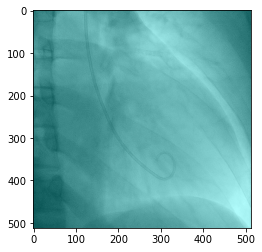

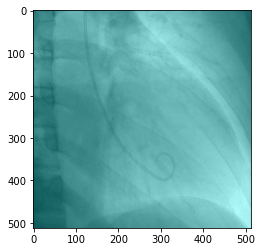

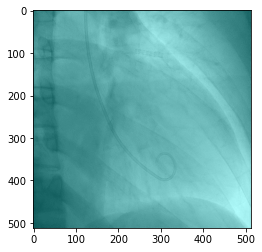

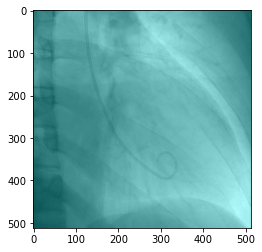

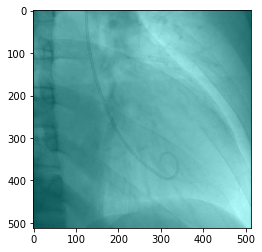

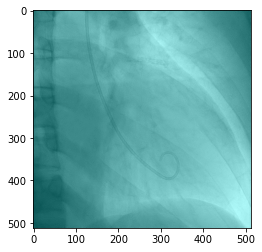

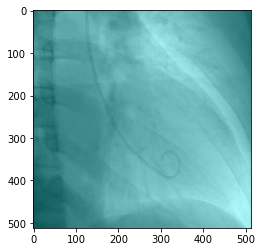

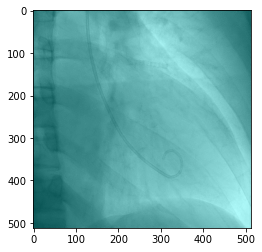

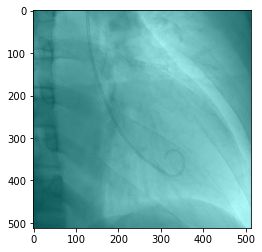

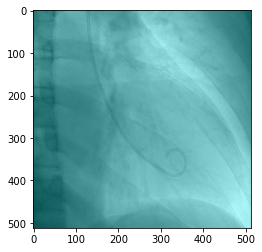

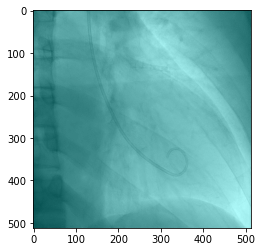

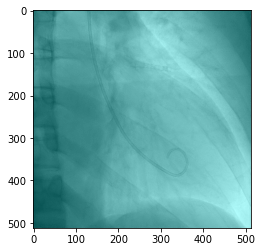

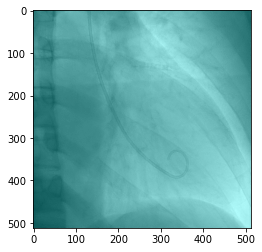

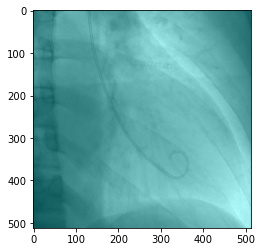

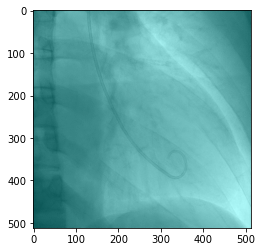

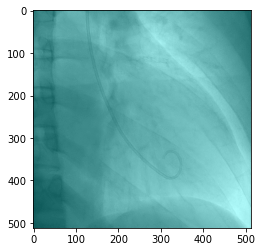

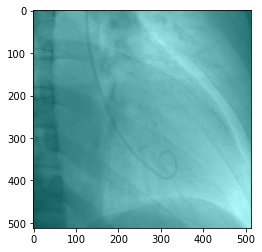

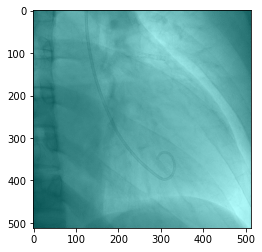

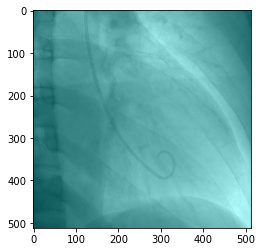

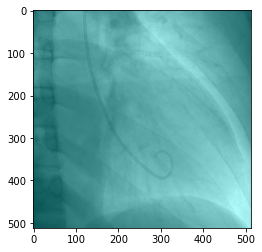

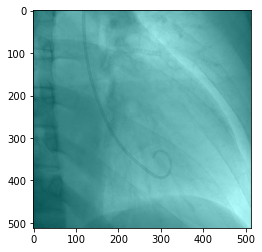

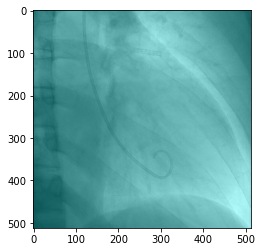

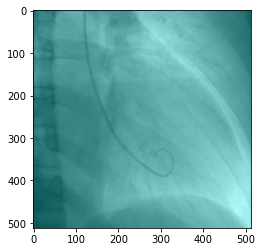

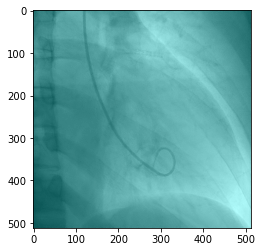

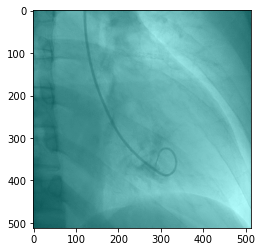

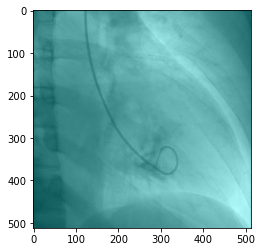

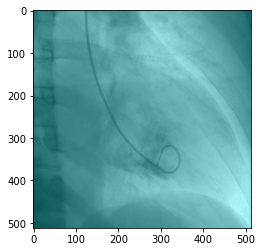

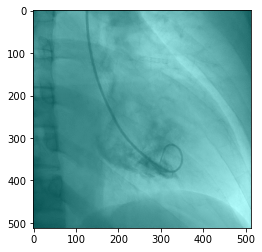

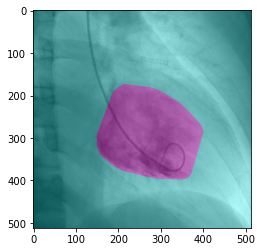

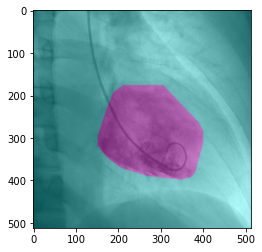

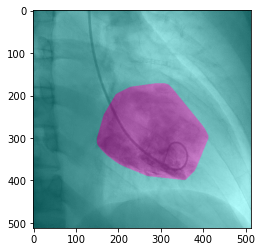

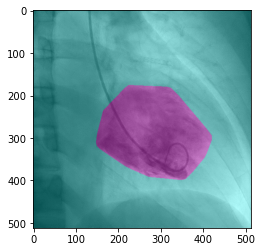

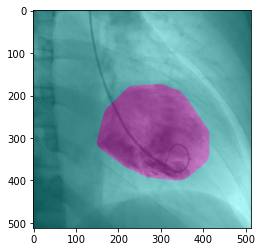

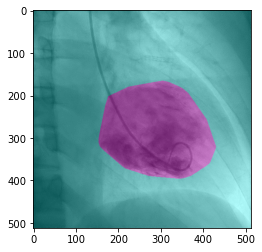

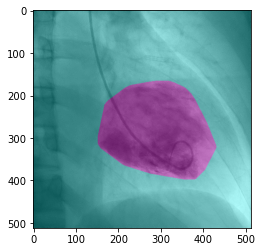

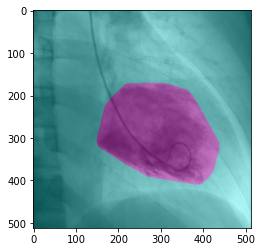

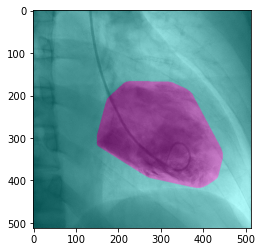

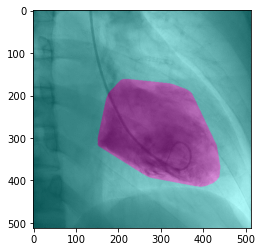

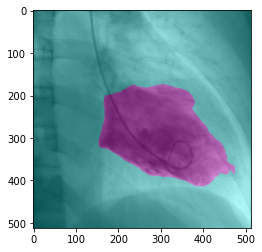

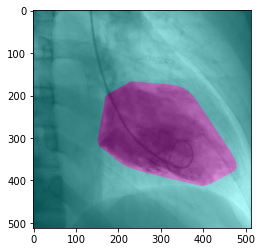

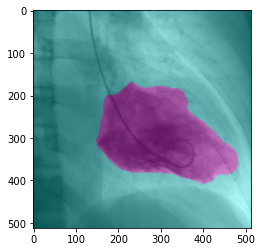

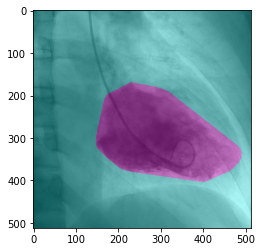

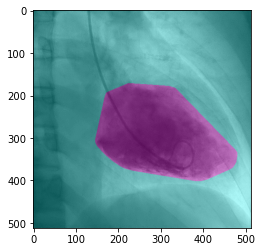

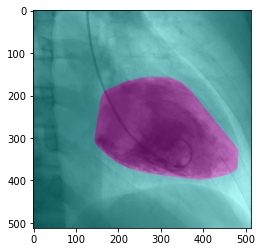

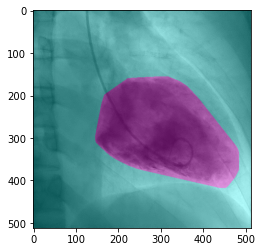

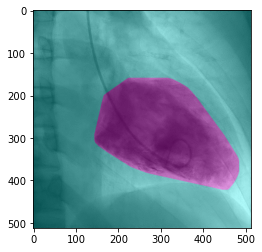

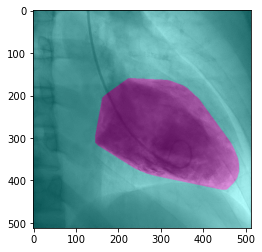

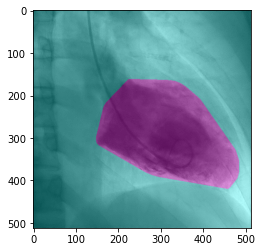

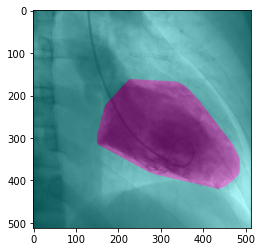

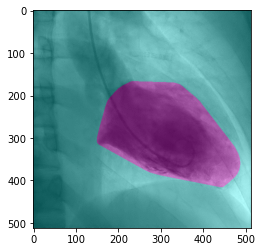

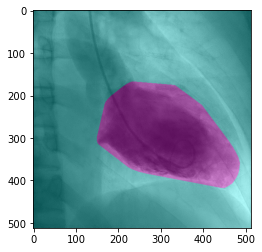

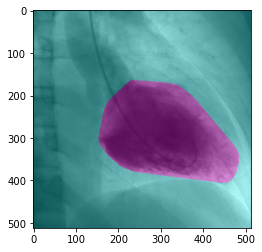

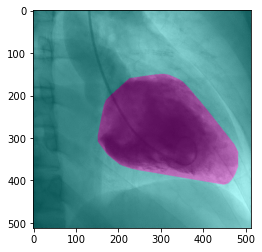

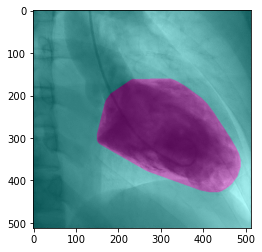

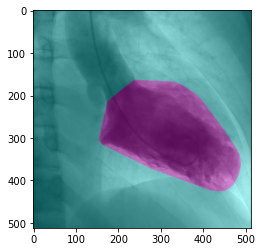

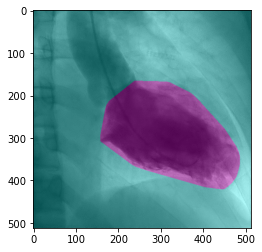

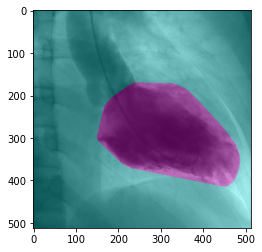

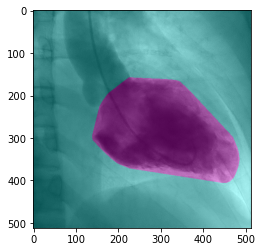

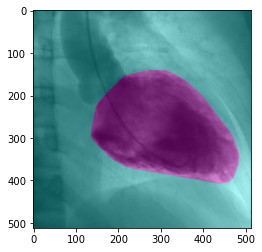

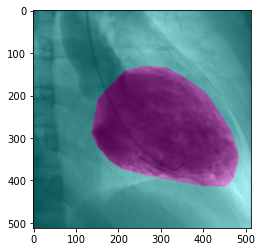

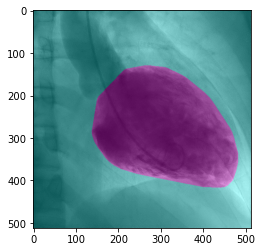

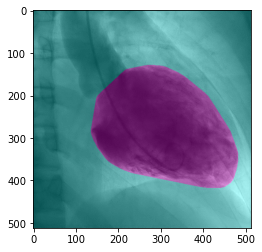

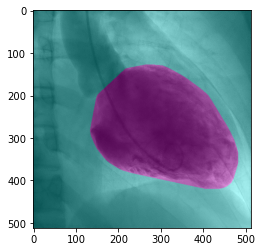

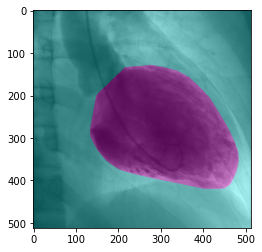

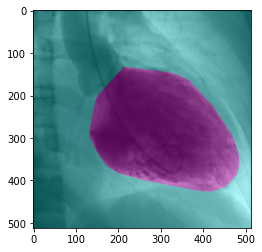

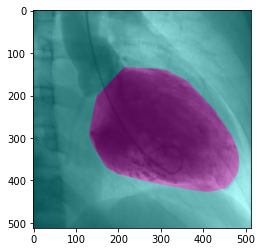

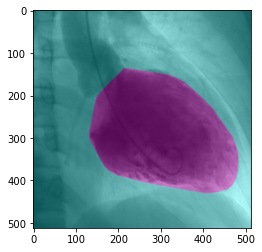

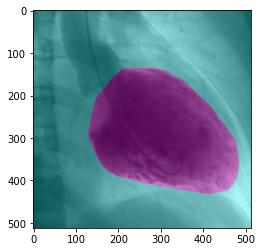

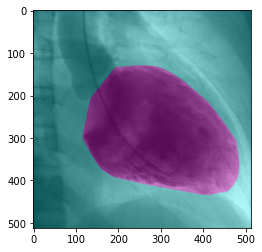

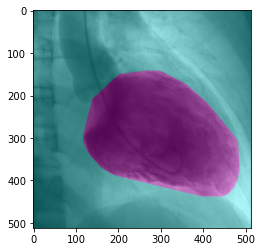

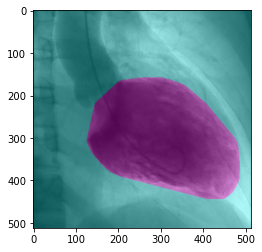

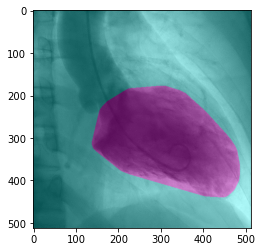

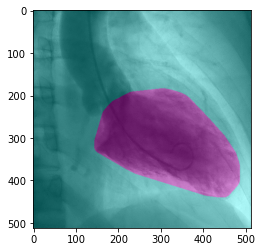

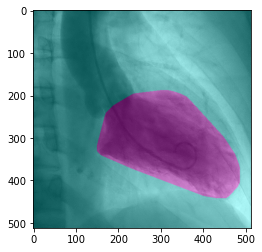

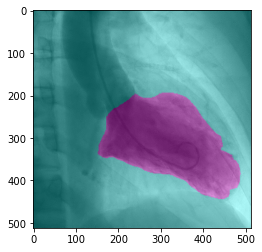

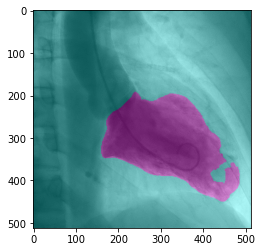

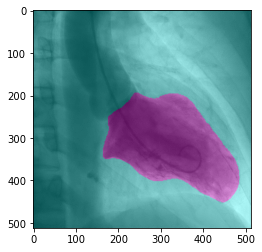

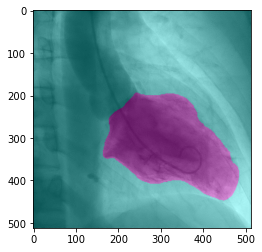

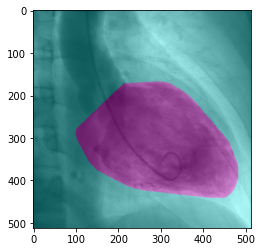

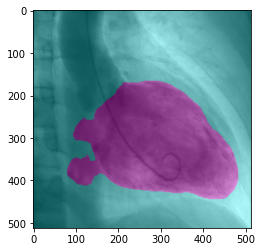

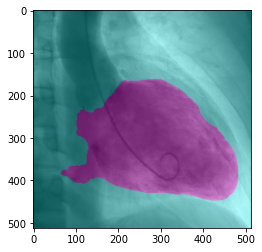

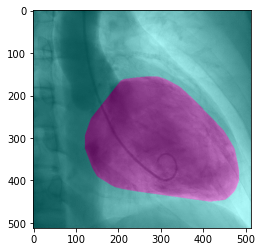

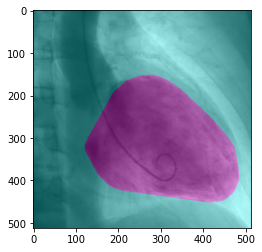

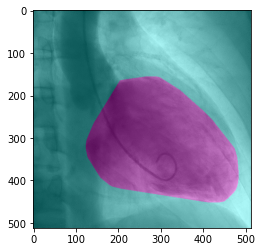

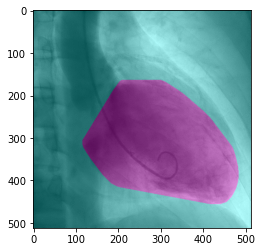

In [ ]:
import os
# postprocessing
post_mask_list = []
for index, mask in enumerate(y_pred):
    h, w = mask.shape
    if not index in range(min_contrast, max_contrast+1):
        mask = np.zeros((h,w), dtype=bool)
    else:
        mask = filter_largest_component(mask)
        mask = filled_mask(mask)
    post_mask_list.append(mask)
post_mask = np.array(post_mask_list)

# show trick of convexhull
adj_mask_list = []
for mask, img in zip(post_mask, x):
    mask = np.array(mask * 255, dtype=np.uint8)
    convex_img, convex_mask = convexhull(img, mask)
    diff = np.logical_xor(convex_mask, mask)
    diff_ratio = 0
    if not np.sum(mask)==0:
        diff_ratio = np.sum(diff)/np.sum(mask)
        #print(np.sum(diff)/np.sum(mask))
        #print(np.sum(diff)/np.sum(convex_mask))
        #print(np.sum(mask)/np.sum(convex_mask))
    if diff_ratio>=0.00030:
        adj_mask = mask
#         plt.imshow(img, cmap='gray')
#         plt.imshow(mask, cmap='cool', alpha=0.3)
    else:
        adj_mask = mask = convex_mask
        plt.imshow(img, cmap='gray')
        plt.imshow(convex_mask, cmap='cool', alpha=0.3)
    adj_mask_list.append(adj_mask)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='cool', alpha=0.3)
    plt.show()
adj_mask = np.array(adj_mask_list)
# EF calculation
result_ef = automatically_calculate_ef(image_arr, adj_mask)
# mse
result_list = []
print('ground_truth_ef', test['ground_truth_ef'])
caseid = os.path.basename(os.path.dirname(dcm_path))
gt_ef = test['ground_truth_ef']
for key in result_ef.keys():
    
    print(key)
    avg_ef = result_ef[key]['avg_ef']
    mse_ef = round(mean_squared_error([gt_ef], [avg_ef]), 5)
    rmse = np.sqrt(mse_ef)
    relative_error = round((avg_ef-gt_ef)/gt_ef, 5)
    result_list.append([caseid, key, gt_ef, avg_ef, mse_ef, rmse, relative_error])
    print(mse_ef)

In [50]:
import pandas as pd
df = pd.DataFrame(result_list, columns = ["caseid", "methods","gt_ef", "avg_ef", "mse", "rmse", "relative_error"])
df

caseid       methods  gt_ef  avg_ef      mse      rmse  \
0  2C6429_apical_hypo    minAreaRec  0.583   0.634  0.00260  0.050990   
1  2C6429_apical_hypo  extremepoint  0.583   0.642  0.00348  0.058992   
2  2C6429_apical_hypo       ellipse  0.583   0.624  0.00168  0.040988   

   relative_error  
0         0.08748  
1         0.10120  
2         0.07033